# Example
In cell below insert your initial parameters. If some of them are not required for your model, simply pass 0 value (for numbers). 
Some parameters are necessary only for specific cases like roughness (used by package when logarithmic profile is set) and they are omitted during computation. 

<div class="alert alert-block alert-warning"><b>ATTENTION:</b> 
Make sure that the length of your arrays match, like:  girths and chords</div>

More information can be found in code comments below.

In [1]:
# varaibles.py for jupyter
import os
import numpy as np
import time
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

mgirths =  np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00])
jgirths = np.array([0.00, 1./4, 1./2, 3./4, 1.00])


out = Output(case_name='my_case_name',
             case_dir=os.path.abspath(''),
             name=os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
             file_name='my_file_name')

solver = Solver(n_spanwise=30,
                n_chordwise=6,
                interpolation_type='spline')

conditions = Conditions(leeway_deg=5.,    
                        heel_deg=10.,    
                        SOG_yacht=4.63,  
                        tws_ref= 4.63,     
                        alpha_true_wind_deg= 50., 
                        reference_water_level_for_wind_profile=-0.,
                        wind_exp_coeff=0.1428,
                        wind_reference_measurment_height=10.,
                        rho=1.225,
                        wind_profile='exponential',
                        roughness=0.05)


rig = Rig(main_sail_luff=12.4,
          jib_luff=10.0,
          foretriangle_height=11.50,
          foretriangle_base=3.90,
          sheer_above_waterline=1.2,
          boom_above_sheer=1.3,
          rake_deg=92.,
          mast_LOA=0.15,
          sails_def='jib_and_main')

main = MainSail(centerline_twist_deg=None,
                girths=np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00]),
                chords=np.array([4.00, 3.82, 3.64, 3.20, 2.64, 2.32, 2.00]),
                camber=5*np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

jib = JibSail(centerline_twist_deg=None,
             girths=np.array([0.00, 1./4, 1./2, 3./4, 1.00]),
             chords=np.array([3.80, 2.98, 2.15, 1.33, 0.5]),
             camber=0*np.array([0.01, 0.01, 0.01, 0.01, 0.01]),
             camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5]))

csys = Csys(reference_level_for_moments=np.array([0, 0, 0]))
keel = Keel(center_of_lateral_resistance_upright=np.array([0, 0, -1.0]))


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [2]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail
from pySailingVLM.solver.panels_plotter import plot_cp

In [3]:
csys_transformations = CSYS_transformations(
    conditions.heel_deg, conditions.leeway_deg,
    v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)


w = Wind(conditions)
s = Sail(solver, rig, main, jib, csys_transformations)
sail_set = s.sail_set
hull = HullGeometry(rig.sheer_above_waterline, rig.foretriangle_base, csys_transformations, keel.center_of_lateral_resistance_upright)
myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)

inviscid_flow_results = InviscidFlowResults(sail_set, csys_transformations, myvlm)
inviscid_flow_results.estimate_heeling_moment_from_keel(hull.center_of_lateral_resistance)

Cell below displays computations and saves integrals to output file.
<div class="alert alert-block alert-info">
<b>Tip:</b> For proper rendering of matplotlib figures in jupyter notebooks insert <em>%matplotlib widget</em> before calling plot functions.
</div>

Preparing visualization.


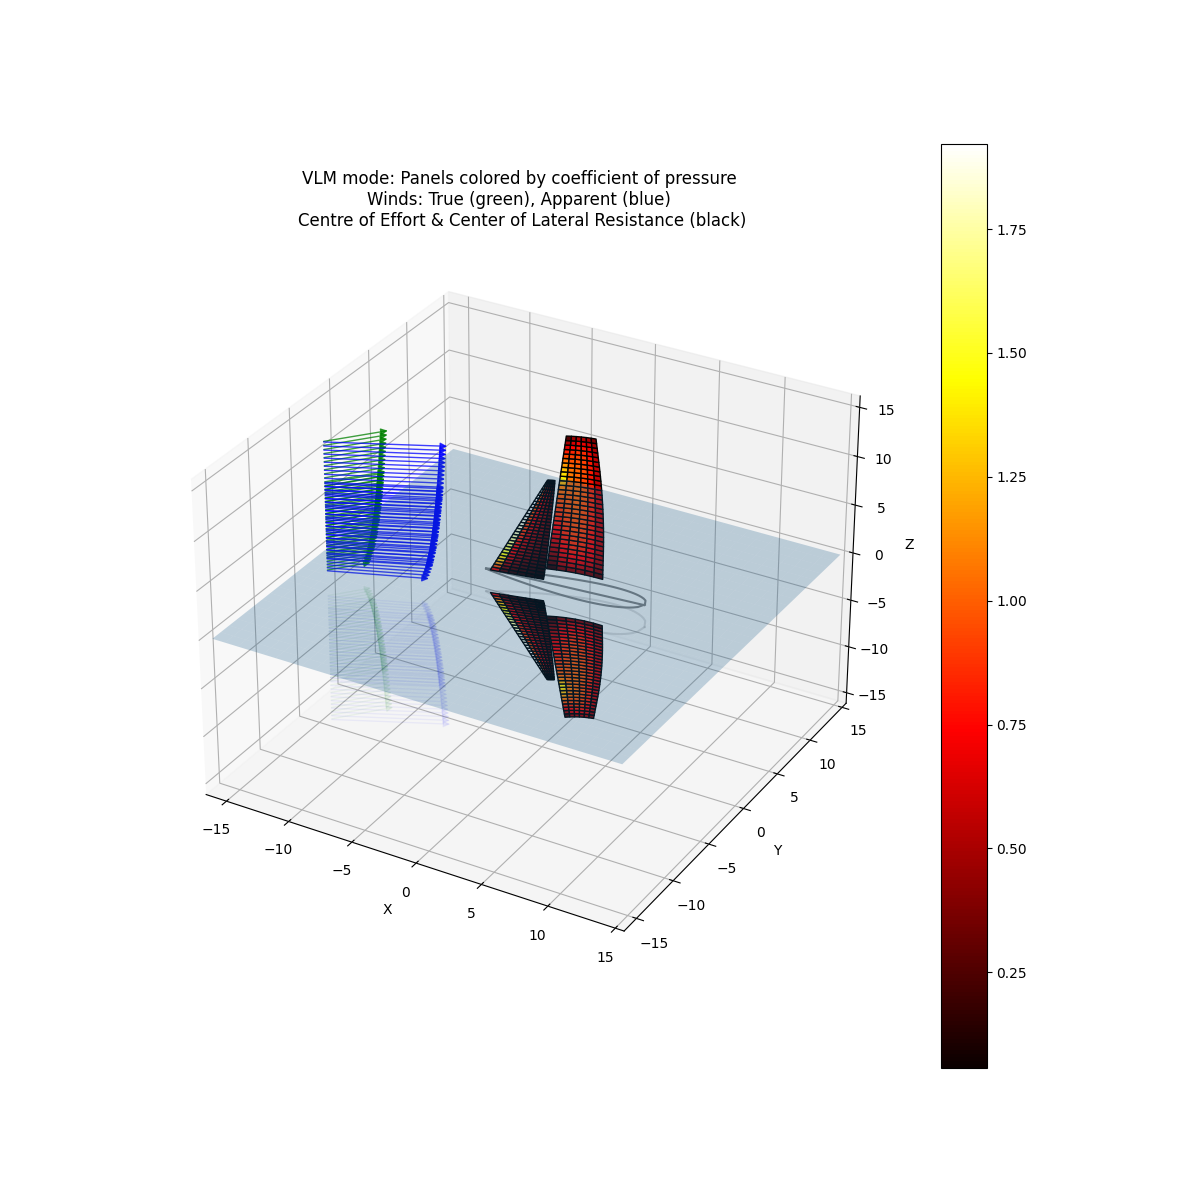

In [4]:
%matplotlib widget
print("Preparing visualization.")   
display_panels_xyz_and_winds(myvlm, inviscid_flow_results, myvlm.inlet_conditions, hull, show_plot=True) # add show_apparent_induced_wind=True for apparent + induced wind 
df_components, df_integrals, df_inlet_IC = save_results_to_file(myvlm, csys_transformations, inviscid_flow_results, s.sail_set, out.name, out.file_name)

Lets see our integrals :)

In [5]:
print(f"-------------------------------------------------------------")
print(f"Notice:\n"
  f"\tThe forces [N] and moments [Nm] are without profile drag.\n"
  f"\tThe the _COG_ CSYS is aligned in the direction of the yacht movement (course over ground).\n"
  f"\tThe the _COW_ CSYS is aligned along the centerline of the yacht (course over water).\n"
  f"\tNumber of panels (sail s.sail_set with mirror): {s.sail_set.panels.shape}")

df_integrals

-------------------------------------------------------------
Notice:
	The forces [N] and moments [Nm] are without profile drag.
	The the _COG_ CSYS is aligned in the direction of the yacht movement (course over ground).
	The the _COW_ CSYS is aligned along the centerline of the yacht (course over water).
	Number of panels (sail s.sail_set with mirror): (720, 4, 3)


,Quantity,Value
0,F_jib_total_COG.x,-193.195405
1,F_jib_total_COG.y,441.534080
2,F_jib_total_COG.z,-31.197805
3,F_main_sail_total_COG.x,-396.195303
4,F_main_sail_total_COG.y,1138.428140
5,F_main_sail_total_COG.z,-216.581980
6,F_sails_total_COG.x,-589.390709
7,F_sails_total_COG.y,1579.962220
8,F_sails_total_COG.z,-247.779785
9,F_sails_total_COW.x,-724.850680


Compute aerodynamic parameters:

Make model plot in 2D colored by pressure coefficients:

In [6]:
from pySailingVLM.solver.panels_plotter import plot_cp
plot_cp(sail_set.zero_mesh, myvlm.p_coeffs, out.name)

Loading BokehJS ...

In [7]:
from pySailingVLM.solver.coefs import get_C
cl = get_C(myvlm.panels, myvlm.areas, myvlm.lift, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)
cd = get_C(myvlm.panels, myvlm.areas, myvlm.drag, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)

In [8]:
k = int(myvlm.panels.shape[0] / (solver.n_spanwise * solver.n_chordwise * 2) ) # *2 in denominator due to underwater part

sail_areas = np.split(myvlm.areas, (2*k))
section_areas = np.zeros((k, solver.n_spanwise), dtype=float) # reshaped in proper way array with areas
sail_cps = np.split(myvlm.cp, (2*k))
sail_section_mean_cp_z = np.zeros((k, solver.n_spanwise), dtype=float)
y1_data_list = []
y2_data_list = []
# cl for every panel in all sails
CLs = np.zeros((k, 1), dtype=float) # array with CL per sail
# iterating only above water
for i in range(k):
    for j in range(solver.n_spanwise):   
        section_sail_areas = sail_areas[i].reshape(solver.n_chordwise, solver.n_spanwise)[:,j]
        section_areas[i, j] = np.sum(section_sail_areas)

        arr = sail_cps[i][:, 2].reshape(solver.n_chordwise, solver.n_spanwise).transpose()
        mean_section_cp_z = np.sum(arr, axis=1) / solver.n_chordwise
        sail_section_mean_cp_z[i] = mean_section_cp_z

    CLs[i] = np.sum(section_areas[i] * cl[i]) / np.sum(section_areas[i])
    y1_data_list.append(cl[i] / CLs[i])
    y2_data_list.append(cd[i] / CLs[i])
    
#a = CL / np.deg2rad(AoA_deg)

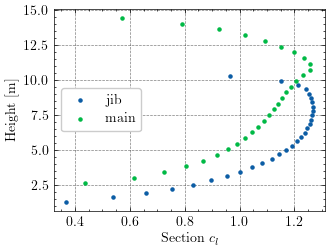

<Figure size 350x262.5 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import scienceplots 
%matplotlib inline

plt.style.use(['science', 'grid'])
section_number = np.arange(1, myvlm.n_spanwise+1, 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y1_data_list[0], sail_section_mean_cp_z[0], label='jib', s=5)
ax1.scatter(y1_data_list[1], sail_section_mean_cp_z[1], label='main', s=5)
plt.ylabel('Height [m]')
plt.xlabel(r'Section $c_l$')
plt.legend(loc='center left')
ax1.autoscale(tight=True)
plt.savefig('sailing_vlm_cl', dpi=300)
plt.show()

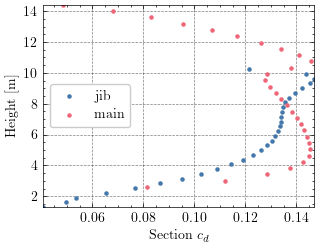

In [10]:
import matplotlib.pyplot as plt
import scienceplots 
%matplotlib inline

plt.style.use(['science', 'grid', 'bright'])

section_number = np.arange(1, myvlm.n_spanwise+1, 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(y2_data_list[0], sail_section_mean_cp_z[0], label='jib', s=5)
ax1.scatter(y2_data_list[1], sail_section_mean_cp_z[1], label='main', s=5)
plt.ylabel('Height [m]')
plt.xlabel(r'Section $c_d$')
plt.legend(loc='center left')
ax1.autoscale(tight=True)
plt.savefig('sailing_vlm_cd', dpi=300)
plt.show()

Thats all. Experiment and play with this code on your own.